## Exercise 6: Deep Q-learning (DQN)

In this exercise, you will implement DQN by [Mnih et al.](https://arxiv.org/abs/1312.5602).

DQN was the first algorithm that was able to play Atari games while only using images as an input, showing the potential of deep reinforcement learning.

<img src="img/space_invaders.png" alt="Drawing" style="width: 400px;"/>

### 1. Continuous State Spaces

In a previous exercise, we looked at tabular Q-learning, which uses a distinct Q-value for each individual state. Unfortunately, often the number of possible states is too high. Thus, by using function approximation methods like neural networks we can learn a parameterized Q-value function that can be applied on the whole state.

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Q(nn.Module):
    """ A Q-function network."""
    def __init__(self, state_dim, action_dim, hidden_dim=50):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.as_tensor(x).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The above implementation uses pytorch which is a very successfull deep learning network. In this exercise sheet we only need the basics of pytorch, but if you are interested the official pytorch documentation has some nice 60min [tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

### 2. Experience Replay
While the agent navigates through the environment, we store the transitions that the agent experiences in a *replay buffer*. With this we can reuse older experience, making the method more sample efficient and break the temporal correlations of the transitions.

In [114]:
import gymnasium
from collections import deque
import random
import numpy as np

env =  gymnasium.make("MountainCar-v0")
rb = deque(maxlen=30)  # First in first out queue.

# For demonstration purposes we fill the replay buffer by choosing 100 random actions.
state = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # We choose a random action
    next_state, reward, terminated, truncated, _ = env.step(action)

    rb.append([state, action, reward, next_state, terminated])
    state = next_state

For training neural networks one typically uses a minibatch of the transitions saved in the replay buffer.

In [ ]:
def sample_batch(replay_buffer, batch_size):
    return [torch.tensor(e, dtype=torch.float) for e in zip(*random.choices(replay_buffer, k=batch_size))]

In [ ]:
sample_batch(rb, 5)  # Returns list with (state, action, next_state, reward, done)

### 3. DQN

In this section, you will implement DQN as described in the lecture. The `Task` is to fill the missing main DQN implementation.

In [107]:
from collections import namedtuple

import torch.optim as optim
from tqdm import trange


EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self, env, gamma, lr=0.001, maxlen=100000, batch_size=64):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        self.env = env
        self.q = Q(state_dim, action_dim)
        self.q_target = Q(state_dim, action_dim)

        self.gamma = gamma
        self.q_optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.replay_buffer = deque(maxlen=maxlen)

    def get_action(self, x, epsilon):
        if np.random.uniform() < epsilon:
            return np.random.randint(self.action_dim)
        return self.q(x).argmax().item()

    def train(self, episodes, epsilon, update_freq=5):
        stats = EpisodeStats(episode_lengths=np.zeros(episodes), episode_rewards=np.zeros(episodes))

        training_steps = 0

        episode_range = trange(episodes)
        for e in episode_range:
            state, _ = self.env.reset()
            while True:
                action = self.get_action(state, epsilon)
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[e] += reward
                stats.episode_lengths[e] += 1
                
                # TODO: TASK - Implement

                # TASK 1: Add the samples to the replay buffer. Look at the code from above!
                self.replay_buffer.append([state, action, reward, next_state, terminated])
                
                # We sample a transition batch.
                bs, ba, br, bns, bterm = sample_batch(self.replay_buffer, self.batch_size)

                # TASK 2: Calculate the temporal difference target.
                with torch.no_grad():
                    btarget = br + self.gamma * (1 - bterm) * self.q_target(bns).max(dim=1)[0]
                
                current_prediction = self.q(bs)[torch.arange(self.batch_size).long(), ba.long()]
                loss = torch.square(current_prediction - btarget).mean()

                self.q_optimizer.zero_grad()  # Delete the outdated gradients.
                loss.backward()
                self.q_optimizer.step()

                if training_steps % update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                    
                if truncated or terminated:
                    break

                state = next_state
                training_steps += 1
            episode_range.set_description(f"Episode Reward {stats.episode_rewards[e]} ")

        return stats

#### 4. Solving Cart Pole

We can start with the learning :). If the implementation is correct, you should achieve an episode reward of $200$ in the first $100$ episodes.

Other environments that you can try are: [Acrobot-v1](https://gymnasium.farama.org/environments/classic_control/acrobot/) or [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

In [108]:
env = gymnasium.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200)
dqn = DQNAgent(env, gamma=0.99)

stats = dqn.train(episodes=200, epsilon=0.1, update_freq=100)

Episode Reward 200.0 : 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]


**An example rollout**:

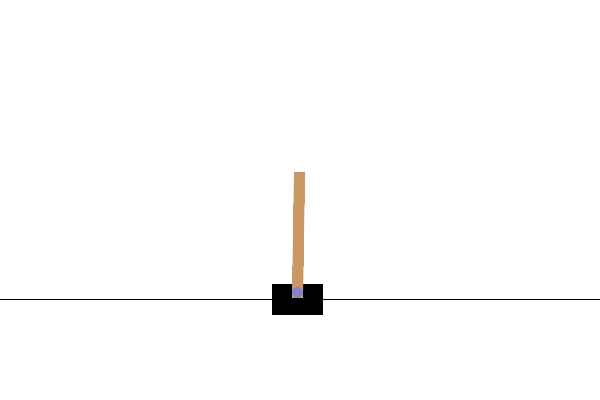

In [110]:
from visualization import save_rgb_animation
from IPython.display import Image as IImage
from functools import partial


def rendered_rollout(policy, env, max_steps=200):
    steps = 0
    
    state, _ = env.reset()
    imgs = [env.render()]

    while steps < max_steps:
        action = policy(state)
        state, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        steps += 1

        if terminated or truncated:
            break
    
    return imgs

imgs = rendered_rollout(partial(dqn.get_action, epsilon=0.1), env)
save_rgb_animation(imgs, f"{env.spec.id}.gif", duration=40)
IImage(filename=f"{env.spec.id}.gif")

**Visualization of the episode stats:**

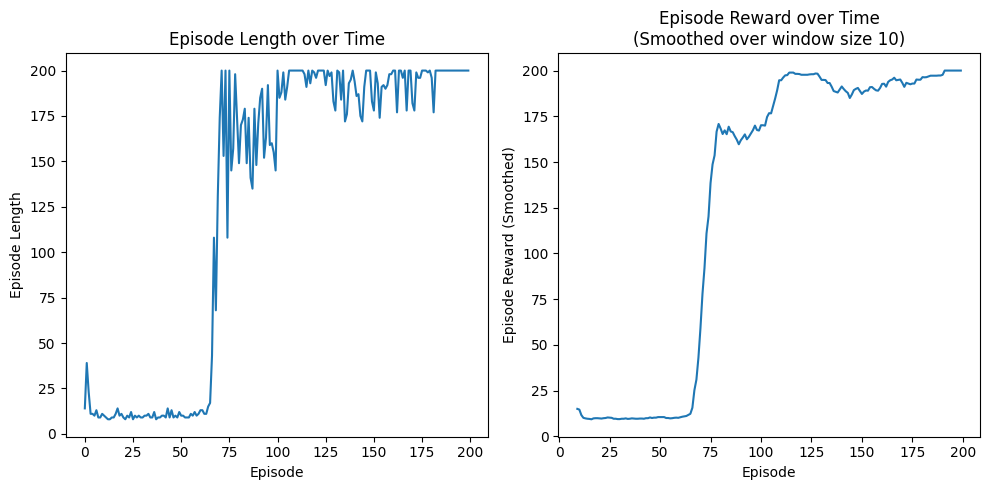

In [112]:
from visualization import plot_episode_stats

plot_episode_stats(stats)